# BM3 GNN Pred

In [1]:
from typing import *
import numpy as np
from functools import partial

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

In [2]:
DEVICE = torch.device("cpu")

In [3]:
from tomopt.volume.layer import Layer

def get_volume(size: float = 0.2, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(0.5, 0.5, 1 - (i * (size) / n_panels)), init_xy_span=(1.0, 1.0), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - size, size, -size), decimals=1):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(0.5, 0.5, 0.2 - (i * (size) / n_panels)), init_xy_span=(1.0, 1.0), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [4]:
volume = get_volume(device=DEVICE)

In [5]:
muons = MuonBatch(generate_batch(250), init_z=volume.h, device=DEVICE)

In [6]:
gen = RandomBlockPassiveGenerator(
        block_size=None, volume=volume, sort_x0=False, enforce_diff_mat=True, materials=["beryllium", "carbon", "silicon", "iron", "lead"], block_size_max_half=False
    )

In [7]:
volume.load_rad_length(*gen.get_data())

In [8]:
volume(muons)

In [9]:
volume.target

tensor([0.1932])

In [10]:
sb = PanelScatterBatch(muons, volume)

## GNN inferer

In [11]:
model = torch.jit.load('../../mode_muon_tomo_inference/dev/exported_models/bm3_traced.pt')

In [12]:
type(model)

torch.jit._script.RecursiveScriptModule

In [13]:
dvi = DeepVolumeInferer(model=model, base_inferer=PanelX0Inferer(volume), volume=volume)

In [14]:
dvi.in_vars, dvi.in_var_uncs

([], [])

In [15]:
dvi.add_scatters(sb)

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:246: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [16]:
dvi.in_vars[0].shape, dvi.in_var_uncs[0].shape

(torch.Size([250, 8]), torch.Size([250, 8]))

In [17]:
%%time
p,w = dvi.get_prediction()

CPU times: user 3.95 s, sys: 366 ms, total: 4.31 s
Wall time: 1.73 s


In [18]:
torch.exp(p).shape

torch.Size([1, 5, 125])

In [19]:
p

tensor([[[-4.7008e+00, -3.7238e+00, -3.4341e+00, -3.8832e+00, -5.0183e+00,
          -3.5154e+00, -2.6191e+00, -2.3810e+00, -2.8031e+00, -3.9662e+00,
          -3.1240e+00, -2.2921e+00, -2.1211e+00, -2.4859e+00, -3.6614e+00,
          -3.4141e+00, -2.5772e+00, -2.4185e+00, -2.8268e+00, -3.9782e+00,
          -4.3520e+00, -3.6131e+00, -3.4527e+00, -3.9681e+00, -5.0220e+00,
          -3.4761e+00, -2.5160e+00, -2.2628e+00, -2.6511e+00, -3.8748e+00,
          -2.3249e+00, -1.6921e+00, -1.5962e+00, -1.7765e+00, -2.6850e+00,
          -2.0035e+00, -1.5444e+00, -1.4961e+00, -1.6205e+00, -2.3203e+00,
          -2.1872e+00, -1.6336e+00, -1.5821e+00, -1.7683e+00, -2.6699e+00,
          -3.0968e+00, -2.2752e+00, -2.1476e+00, -2.5820e+00, -3.8421e+00,
          -3.1706e+00, -2.1835e+00, -1.9642e+00, -2.3174e+00, -3.5741e+00,
          -2.0144e+00, -1.5281e+00, -1.4610e+00, -1.5887e+00, -2.2818e+00,
          -1.7023e+00, -1.4328e+00, -1.4023e+00, -1.4987e+00, -1.9437e+00,
          -1.8224e+00, -1

In [20]:
%%time
# jacobian(p, dvi.in_var)  # crashes

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


## Loss

In [21]:
x02id = {X0[m]: i for i, m in enumerate(gen.materials)}; x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [22]:
loss = VoxelClassLoss(x02id=x02id, target_budget=None)

In [23]:
l = loss(p, 1, volume); l

Automatically setting cost coefficient to 2.881141424179077


tensor([2.8811], grad_fn=<AddBackward0>)

In [24]:
jacobian(l, volume.get_detectors()[0].panels[0].xy)

tensor([[-0.4067,  0.4760]])

In [25]:
jacobian(l, volume.get_detectors()[0].panels[0].xy_span)

tensor([[0.2770, 0.1405]])

In [26]:
jacobian(l, volume.get_detectors()[0].panels[0].z)

tensor([[-163.6602]])

## Plotting

In [27]:
class_preds = p.argmax(1).detach().cpu().numpy()

In [28]:
true = volume.get_rad_cube().flatten().reshape((5,5,5))

In [29]:
class_preds = class_preds.reshape(true.shape)

In [30]:
id2x0 = {v:k for k,v in x02id.items()}; id2x0

{0: 0.3528, 1: 0.1932, 2: 0.0937, 3: 0.01757, 4: 0.005612}

In [31]:
def class_to_x0preds(array: np.ndarray, id2x0: Dict[int, float]) -> np.ndarray:
    x0array = np.zeros_like(array, dtype='float32')
    for i in np.unique(array):
        x0array[array == i] = id2x0[i]
    return x0array

In [32]:
x0_preds = class_to_x0preds(class_preds, id2x0)

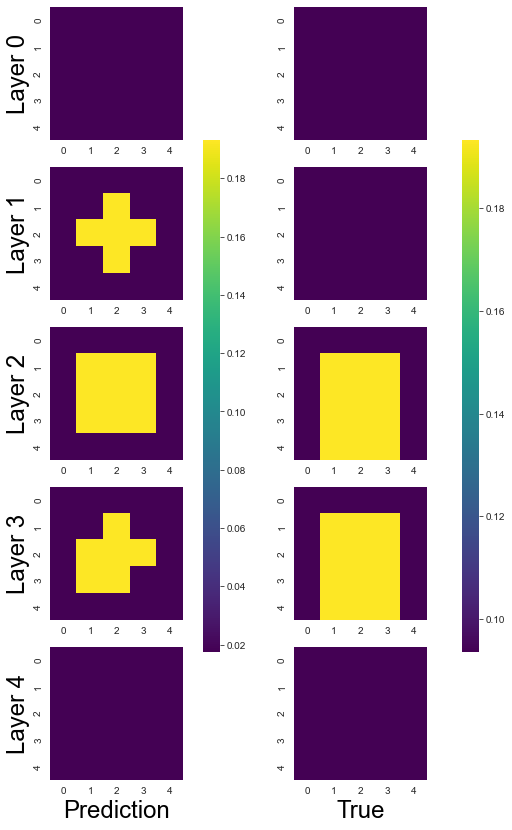

In [33]:
plot_pred_true_x0(x0_preds, true)

In [34]:
def x0targs_to_classtargs(array: np.ndarray, x02id: Dict[float, int]) -> np.ndarray:
    x0array = np.zeros_like(array)
    for i in np.unique(array):
        x0array[array == i] = x02id[min(x02id, key=lambda x:abs(x-i))]
    return x0array

In [35]:
x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [36]:
class_targs = x0targs_to_classtargs(true, x02id)

In [37]:
class_targs

array([[[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]],

       [[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]],

       [[2., 2., 2., 2., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.]],

       [[2., 2., 2., 2., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.],
        [2., 1., 1., 1., 2.]],

       [[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]]], dtype=float32)

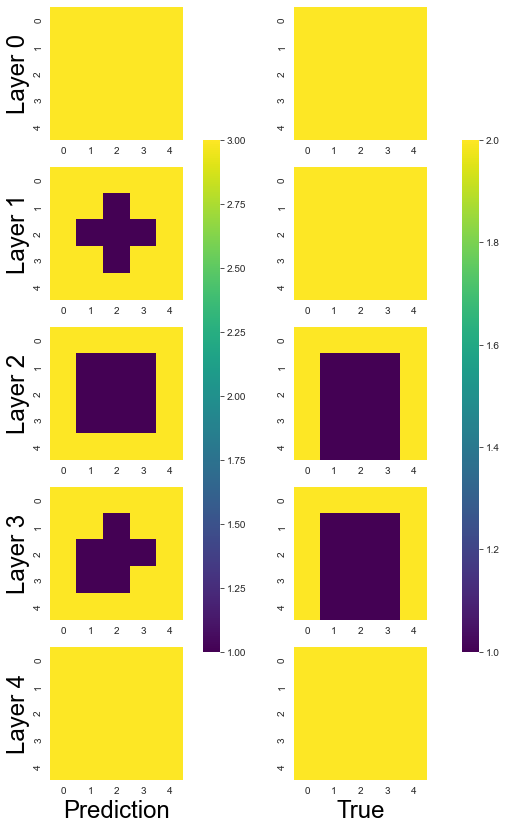

In [38]:
plot_pred_true_x0(class_preds, class_targs)